In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import Image

import matplotlib as mpl
mpl.rcParams.update({'font.size': 10})

%matplotlib nbagg

In [2]:
def sin(theta):
    return np.sin(theta*np.pi/180.)

def cos(theta):
    return np.cos(theta*np.pi/180.)

## Load RIXS

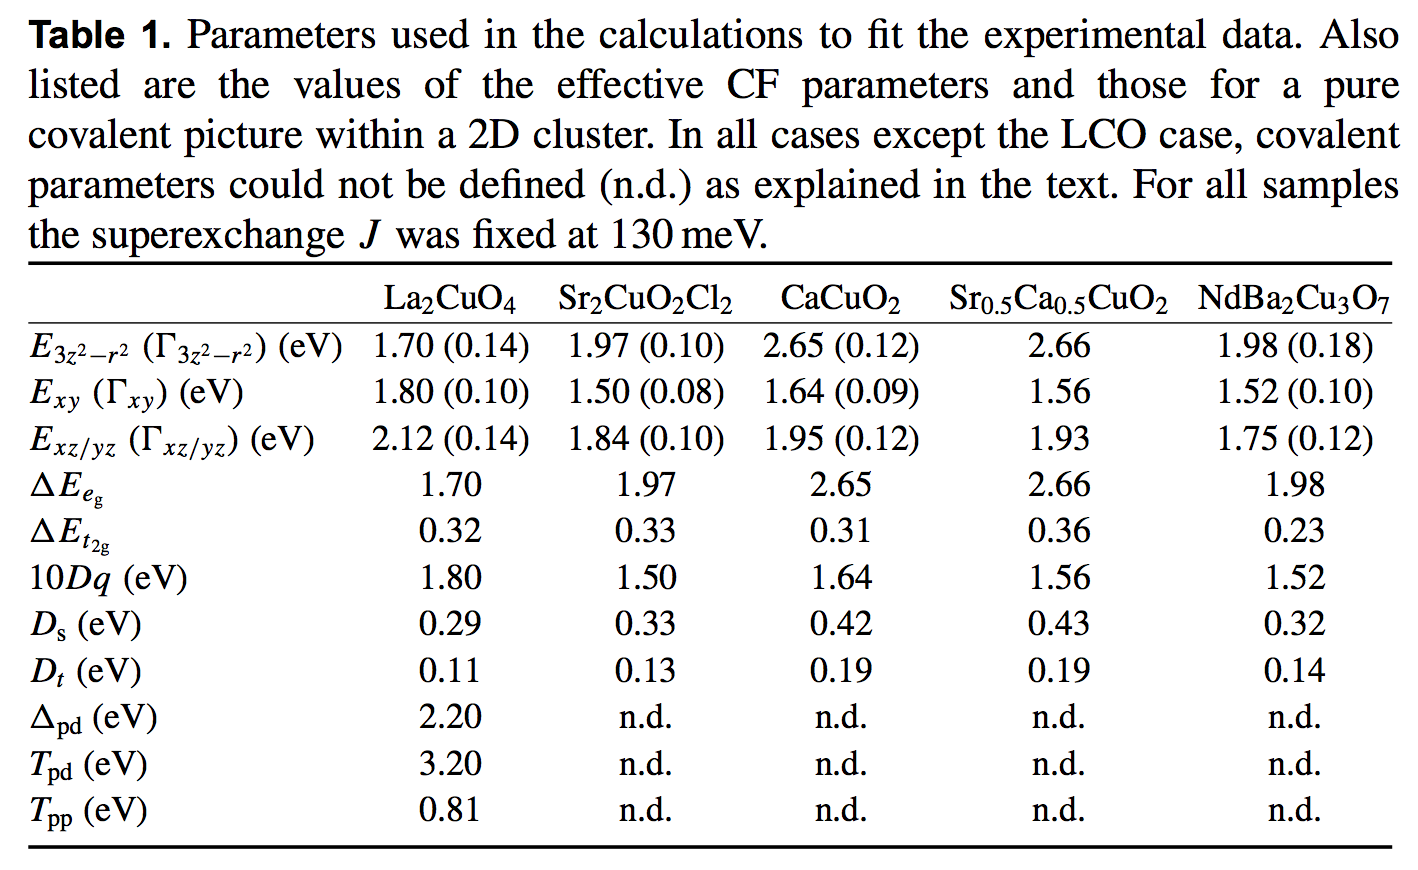

In [3]:
Image('moretti.png')

In [4]:
with open('120meV_exchange/RIXS_pol_11_out.spec') as fin:
    header = [fin.readline() for n in range(4)]

num_spectra = int(header[0][:-1].split(' ')[-1])
Emin1, Emax1 = -7., -3.
E1 = np.linspace(Emin1, Emax1, num_spectra)

file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(1, 1)
data = np.loadtxt(file_name, skiprows=5)
E2 = data[:,0]
RIXSmap = data[:,2::2]

In [5]:
def get_rixs(out_pol, in_pol):
    cutrow = 300

    file_name = 'zero_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap0 = -data[:,2::2]
    
    file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap120 = -data[:,2::2]
    
    RIXSmap = np.vstack((RIXSmap120[:cutrow], RIXSmap0[cutrow:]))
    
    return RIXSmap

pol_iter = [(out_pol, in_pol) for out_pol in range(3) for in_pol in range(3)]
RIXSmaps = [get_rixs(out_pol+1, in_pol+1) for out_pol, in_pol in pol_iter]

## Get XAS

In [6]:
XAS = sum(RIXSmaps).sum(axis=0)
#fig, ax = plt.subplots()
#ax.plot(E1, XAS, '.-')
Eres = E1[np.argmax(XAS)]
print('Resonance at {:.3f}'.format(Eres))

Resonance at -5.200


## Get spectra

In [8]:
spectra = [RIXSmap[:,np.argmax(XAS)] for RIXSmap in RIXSmaps]

spectra_matrix = np.zeros((len(E2), 3, 3))
for spectrum, (in_pol, out_pol) in zip(spectra, pol_iter):
    spectra_matrix[:, in_pol, out_pol] = spectrum

maxval = np.max(spectra_matrix)

## Azimuthal dependence

In [9]:
def rot_mat(u, phi):
    R = np.array([[cos(phi) + u[0]**2*(1-cos(phi)),
                  u[0]*u[1]*(1-cos(phi)) - u[2]*sin(phi), 
                  u[0]*u[2]*(1-cos(phi) + u[1]*sin(phi))],

                 [u[1]*u[0]*(1-cos(phi)) + u[2]*sin(phi),  
                  cos(phi) + u[1]**2 *(1-cos(phi)),
                  u[1]*u[2]*(1-cos(phi)) -u[0]*sin(phi)],

                 [u[2]*u[0]*(1-cos(phi)) - u[1]*sin(phi),
                  u[2]*u[1]*(1-cos(phi)) + u[0]*sin(phi),
                  cos(phi) + u[2]**2 *(1-cos(phi))]
                 ])
    return R

def get_orbital_ints_azi(a_pol, e_pol, u, phi):
    
    R = rot_mat(u, phi)
    absorption_pol = np.matmul(R, a_pol)
    emitted_pol = np.matmul(R, e_pol)

    M = np.outer(emitted_pol, absorption_pol)
    spectrum_at_pol = np.abs((M*spectra_matrix).sum(axis=(1,2)))**2

    mag = np.interp(0.25, E2, spectrum_at_pol)
    z = np.interp(1.68, E2, spectrum_at_pol)
    xy = np.interp(1.79, E2, spectrum_at_pol)
    xz = np.interp(2.10, E2, spectrum_at_pol)
    
    #print("th_i {:.1f} th_o {:.1f}".format(th_i, th_o))
    #print("absorption {}".format(absorption_pol))
    #print("emision {}".format(emitted_pol))
    
    return mag, z, xy, xz

<IPython.core.display.Javascript object>


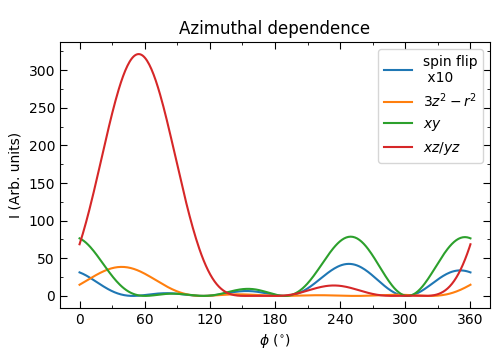

In [35]:
th_i = 120
tth = 130
th_o = tth - th_i

a_pol = np.array([sin(th_i), 0, cos(th_i)])
e_pol = 1/np.sqrt(2) * np.array([sin(th_o), 1, cos(th_o)])

Q_ang = th_o + (180-tth)/2
u = np.array([cos(Q_ang), 0, sin(Q_ang)])

phis = np.linspace(0, 360, 360)
intensities = np.array([get_orbital_ints_azi(a_pol, e_pol, u, phi) for phi in phis])

fig, ax = plt.subplots(figsize=(5, 3.5))

ax.plot(phis, intensities[:,0]*10, label='spin flip\n x10')
ax.plot(phis, intensities[:,1], label='$3z^2-r^2$')
ax.plot(phis, intensities[:,2], label='$xy$')
ax.plot(phis, intensities[:,3], label='$xz/yz$')
ax.set_xlabel('$\phi$ ($^{\circ}$)')
ax.set_ylabel('I (Arb. units)')
ax.legend()

ax.tick_params(which='major', direction='in', bottom=True, top=True, left=True, right=True, length=5)
ax.tick_params(which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=2)
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(60))
ax.xaxis.set_minor_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.set_title(r'Azimuthal dependence')

fig.subplots_adjust(bottom=0.12, left=0.12, right=0.98)

fig.savefig('azimuthal.pdf')